## using the persistence concept of InMemory

In [176]:
from typing import TypedDict, Annotated
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
import time

load_dotenv()

True

In [177]:
class Joke(TypedDict):
    topic: str
    joke: str
    explanation: str
    rephrase: str
    

In [178]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")

In [179]:
def generate_joke(state:Joke) -> Joke:
    print("Step 1: I am a Joke generator llm.")
    prompt= f"Help me generate a joke related to the topic: \n {state['topic']}"
    response=gpt_llm.invoke(prompt)
    print("Joke generation is completed")

    return {'joke':response.content}


In [180]:
def explain_joke(state:Joke) -> Joke:
    print("Step 2: I am a Joke explainer llm.")
    prompt= f"Help me explain the joke: \n {state['joke']}"
    time.sleep(60)
    response=gpt_llm.invoke(prompt)
    print("Joke explanation is completed")

    return {'explanation':response.content}


In [183]:
def rephrase_joke(state:Joke) -> Joke:
    print("Step 3: I am a Joke re-generator llm")
    prompt= f"Help me better this joke: \n {state['joke']}"
    response=gpt_llm.invoke(prompt)
    print("Joke re-generation is completed")

    return {'rephrase':response.content}


In [184]:
graph=StateGraph(Joke)

In [185]:
graph.add_node("generate_joke",generate_joke)
graph.add_node("explain_joke",explain_joke)
graph.add_node("rephrase_joke",rephrase_joke)
graph.add_edge(START,"generate_joke")
graph.add_edge("generate_joke","explain_joke")
graph.add_edge("explain_joke","rephrase_joke")
graph.add_edge("rephrase_joke", END)

checkpoint= InMemorySaver()

workflow=graph.compile(checkpointer=checkpoint)


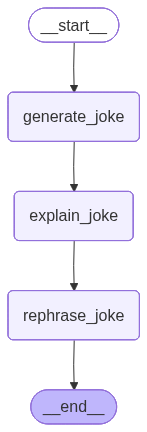

In [186]:
display(Image(workflow.get_graph().draw_mermaid_png()))

## we have simulated a fault tolerance concept. Workflow is interuppted in the middle.

In [187]:
config_1= {"configurable":{"thread_id":"123"}}
try:
    print("Running the joke generation process.")
    workflow.invoke({"topic":"Large langauge model"}, config=config_1)
except KeyboardInterrupt:
     print("❌ Kernel manually interrupted (crash simulated).")


Running the joke generation process.
Step 1: I am a Joke generator llm.
Joke generation is completed
Step 2: I am a Joke explainer llm.
❌ Kernel manually interrupted (crash simulated).


In [188]:
workflow.get_state(config_1)

StateSnapshot(values={'topic': 'Large langauge model', 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!'}, next=('explain_joke',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fdf-7dcb-6b82-8001-f4ee3718c5b0'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-13T06:29:27.548799+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fdf-6e0f-68ce-8000-4f2eb26ad2e6'}}, tasks=(PregelTask(id='886dbf92-a388-50f7-0a0a-db9860df7058', name='explain_joke', path=('__pregel_pull', 'explain_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=())

## Post invoke state history after the interuption of the execution

In [189]:
list(workflow.get_state_history(config_1))

[StateSnapshot(values={'topic': 'Large langauge model', 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!'}, next=('explain_joke',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fdf-7dcb-6b82-8001-f4ee3718c5b0'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-13T06:29:27.548799+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fdf-6e0f-68ce-8000-4f2eb26ad2e6'}}, tasks=(PregelTask(id='886dbf92-a388-50f7-0a0a-db9860df7058', name='explain_joke', path=('__pregel_pull', 'explain_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'Large langauge model'}, next=('generate_joke',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fdf-6e0f-68ce-8000-4f2eb26ad2e6'}}, metadata={'s

In [190]:
workflow.invoke(None, config=config_1)

Step 2: I am a Joke explainer llm.
Joke explanation is completed
Step 3: I am a Joke re-generator llm
Joke re-generation is completed


{'topic': 'Large langauge model',
 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!',
 'explanation': 'This joke plays on the capabilities and limitations of different types of computational tools. \n\n1. **Large Language Model (LLM)**: The LLM represents advanced AI, designed to understand and generate human language. It can interpret context, emotions, and nuances in communication, giving it a deeper understanding of "problems" beyond just numerical calculations.\n\n2. **Calculator**: A calculator is designed to perform mathematical operations but lacks the capacity for understanding or interpreting more complex problems, especially those that involve language, context, or emotional nuance.\n\nThe humor arises from the anthropomorphism of the LLM as having emotions and relationships, which is a playful exaggeration of the way we typically consider human interactions. The punchline ("under

## Post invoke state history from the failed execution  

In [191]:
list(workflow.get_state_history(config_1))

[StateSnapshot(values={'topic': 'Large langauge model', 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!', 'explanation': 'This joke plays on the capabilities and limitations of different types of computational tools. \n\n1. **Large Language Model (LLM)**: The LLM represents advanced AI, designed to understand and generate human language. It can interpret context, emotions, and nuances in communication, giving it a deeper understanding of "problems" beyond just numerical calculations.\n\n2. **Calculator**: A calculator is designed to perform mathematical operations but lacks the capacity for understanding or interpreting more complex problems, especially those that involve language, context, or emotional nuance.\n\nThe humor arises from the anthropomorphism of the LLM as having emotions and relationships, which is a playful exaggeration of the way we typically consider human interactions. T

## Also implemented the time travel - Time travel is to get the checkpoint ID and you can execute your workflow from that checkpoint. Time Travel is used in debugging.

In [192]:
workflow.get_state({"configurable": {"thread_id": "123", "checkpoint_id": "1f0a7fdf-7dcb-6b82-8001-f4ee3718c5b0"}})

StateSnapshot(values={'topic': 'Large langauge model', 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!'}, next=('explain_joke',), config={'configurable': {'thread_id': '123', 'checkpoint_id': '1f0a7fdf-7dcb-6b82-8001-f4ee3718c5b0'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-13T06:29:27.548799+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fdf-6e0f-68ce-8000-4f2eb26ad2e6'}}, tasks=(PregelTask(id='886dbf92-a388-50f7-0a0a-db9860df7058', name='explain_joke', path=('__pregel_pull', 'explain_joke'), error=None, interrupts=(), state=None, result={'explanation': 'This joke plays on the capabilities and limitations of different types of computational tools. \n\n1. **Large Language Model (LLM)**: The LLM represents advanced AI, designed to understand and generate human language. It can interpret context, emoti

In [193]:
workflow.invoke(None, {"configurable": {"thread_id": "123", "checkpoint_id": "1f0a7fdf-7dcb-6b82-8001-f4ee3718c5b0"}})


Step 2: I am a Joke explainer llm.
Joke explanation is completed
Step 3: I am a Joke re-generator llm
Joke re-generation is completed


{'topic': 'Large langauge model',
 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!',
 'explanation': 'This joke plays on a few clever puns and the characteristics of both a large language model (LLM) and a calculator. \n\n1. **Understanding Problems**: LLMs, like the one you\'re interacting with, are designed to understand and generate human language, which includes interpreting complex queries and problems in a conversational way. In contrast, a calculator simply performs mathematical operations without any understanding of context or nuance.\n\n2. **Romantic Relationship Metaphor**: The joke anthropomorphizes the LLM and the calculator as if they were in a romantic relationship. The idea of "breaking up" suggests that the LLM is looking for a partner that can engage on a deeper level, which in this case means someone who can "understand" rather than just compute.\n\n3. **Play on "Calcula

## Post invoke state history after selecting the time travel checkpoint id

In [194]:
list(workflow.get_state_history(config_1))

[StateSnapshot(values={'topic': 'Large langauge model', 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!', 'explanation': 'This joke plays on a few clever puns and the characteristics of both a large language model (LLM) and a calculator. \n\n1. **Understanding Problems**: LLMs, like the one you\'re interacting with, are designed to understand and generate human language, which includes interpreting complex queries and problems in a conversational way. In contrast, a calculator simply performs mathematical operations without any understanding of context or nuance.\n\n2. **Romantic Relationship Metaphor**: The joke anthropomorphizes the LLM and the calculator as if they were in a romantic relationship. The idea of "breaking up" suggests that the LLM is looking for a partner that can engage on a deeper level, which in this case means someone who can "understand" rather than just compute.\n\n3

## You can also update the state by intefering directly with the state history to generate a new output. Example instead of topic "Large langauge model", replaced with "Science"

In [195]:
workflow.update_state({"configurable": {"thread_id": "123", "checkpoint_id": "1f0a7fa8-5691-68b4-8000-c8df47369320","checkpoint_ns": "" }},{'topic':'Science'})

{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a7feb-62a2-6df4-8000-2d98af3f79c9'}}

## Pre invoke state history for updating the state

In [196]:
list(workflow.get_state_history(config_1))

[StateSnapshot(values={'topic': 'Science'}, next=('generate_joke',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7feb-62a2-6df4-8000-2d98af3f79c9'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-10-13T06:34:46.823467+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0a7fa8-5691-68b4-8000-c8df47369320'}}, tasks=(PregelTask(id='25306827-d1cf-8c98-49b1-1802b785612c', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'Large langauge model', 'joke': 'Why did the large language model break up with its calculator?\n\nBecause it found someone who could actually "understand" its problems!', 'explanation': 'This joke plays on a few clever puns and the characteristics of both a large language model (LLM) and a calculator. \n\n1. **Understanding Problems**: LLMs

In [197]:
workflow.invoke(None, {"configurable": {"thread_id": "123", "checkpoint_id": "1f0a7feb-62a2-6df4-8000-2d98af3f79c9"}})

Step 1: I am a Joke generator llm.
Joke generation is completed
Step 2: I am a Joke explainer llm.
Joke explanation is completed
Step 3: I am a Joke re-generator llm
Joke re-generation is completed


{'topic': 'Science',
 'joke': "Why can't you trust atoms? \n\nBecause they make up everything!",
 'explanation': 'This joke is a classic play on words that relies on a double meaning. \n\n1. **Literal Meaning**: Atoms are the fundamental building blocks of matter. Everything in the physical world is made up of atoms. This part of the joke relates to the scientific fact that all substances, including solids, liquids, and gases, are composed of atoms.\n\n2. **Figurative Meaning**: The phrase “make up” can also mean to fabricate or invent a story or lie. When someone "makes up" something, they are not telling the truth.\n\nSo, when the joke says, "Why can\'t you trust atoms? Because they make up everything!" it plays on the dual meaning of "make up." It implies that atoms are untrustworthy because they create all matter, while humorously suggesting they are dishonest because they "make up" everything, much like a person who might tell falsehoods.\n\nThe humor comes from the clever twist o

## Post invoke state history for updating the state

In [198]:
list(workflow.get_state_history(config_1))

[StateSnapshot(values={'topic': 'Science', 'joke': "Why can't you trust atoms? \n\nBecause they make up everything!", 'explanation': 'This joke is a classic play on words that relies on a double meaning. \n\n1. **Literal Meaning**: Atoms are the fundamental building blocks of matter. Everything in the physical world is made up of atoms. This part of the joke relates to the scientific fact that all substances, including solids, liquids, and gases, are composed of atoms.\n\n2. **Figurative Meaning**: The phrase “make up” can also mean to fabricate or invent a story or lie. When someone "makes up" something, they are not telling the truth.\n\nSo, when the joke says, "Why can\'t you trust atoms? Because they make up everything!" it plays on the dual meaning of "make up." It implies that atoms are untrustworthy because they create all matter, while humorously suggesting they are dishonest because they "make up" everything, much like a person who might tell falsehoods.\n\nThe humor comes fro